This File is used to find the length of the longest sentence.

In [1]:
!pip install --upgrade gensim
!pip install seqeval
!pip install torch
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 533.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=6da93e3d936dd9f851025250ef17ad5ccbbf5b516d364f9368633430122ef4d3
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import numpy as np
import gensim.downloader
import pandas as pd
import seqeval as se
from seqeval.metrics import f1_score as f1
# from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import time
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import torch

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
w2v = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


# Q1.1 - Cosine Similarity:

## Find Cosine similarity for:
- “Student”
- “Apple”
- “apple”


In [ ]:
print(f"student: {w2v['student'].shape}")
print(f"Apple: {w2v['Apple'].shape}")
print(f"apple: {w2v['apple'].shape}")

student: (300,)
Apple: (300,)
apple: (300,)


In [ ]:
print(f"Cosine Similarity: ")
print(f"Word most similar to `student`: {w2v.most_similar('student')[0]}")
print(f"Word most similar to `Apple`: {w2v.most_similar('Apple')[0]}")
print(f"Word most similar to `apple`: {w2v.most_similar('apple')[0]}")

Cosine Similarity: 
Word most similar to `student`: ('students', 0.7294867038726807)
Word most similar to `Apple`: ('Apple_AAPL', 0.7456986308097839)
Word most similar to `apple`: ('apples', 0.720359742641449)


# Q1.2 - Data

## Dataset Preparation

### We converted the dataset to csv files so that it can be loaded into a dataframe easily.

In [ ]:
train = pd.read_csv("./drive/MyDrive/SC4002/eng.train.csv", sep=" ", header=None, skip_blank_lines=True)
dev = pd.read_csv("./drive/MyDrive/SC4002/eng.testa.csv", sep=" ", header=None, skip_blank_lines=True)
test = pd.read_csv("./drive/MyDrive/SC4002/eng.testb.csv", sep=" ", header=None, skip_blank_lines=True)

In [ ]:
train.drop(columns=[1, 2], inplace=True)
dev.drop(columns=[1, 2], inplace=True)
test.drop(columns=[1, 2], inplace=True)
train.rename(columns={0: "word", 3: "named_entity"}, inplace=True)
dev.rename(columns={0: "word", 3: "named_entity"}, inplace=True)
test.rename(columns={0: "word", 3: "named_entity"}, inplace=True)

In [ ]:
# for i in range(70, 111):
#     print(f"word: {train.iloc[i]['word']:30}\tNE: {train.iloc[i]['named_entity']}")
# w2v['to']

# Q1.2a I

## We printed the set of Named Entity classes that the train, dev, test dataset has.

#Q1.3a!! Answered here not below.
- For words that are not found in w2v, we replace their vectors with zero vectors of shape (300, ), same shape as the vectors in w2v.
```
for word in range(len(words)):
    if words[word] == ' ':
        # print(f"-{words[word]}-")
        words[word] = '"'
        # print(f"-{words[word]}-")
        y[word] = "O"
    try:
        X.append(w2v[words[word]])
    except Exception as e:
        # print(f"Error: {e}")
        X.append(np.zeros((300,), dtype=float))
```

When loaded into csv, the dataframe ignores the `"` character, so we did some preprocessing to add the `"` character and its label back.

This function is called for all 3 datasets, training, development and test.
```
words_train, X_train, y_train = split_dataset(train, le, "Train")
words_dev, X_dev, y_dev = split_dataset(dev, le, "Development")
words_test, X_test, y_test = split_dataset(test, le, "Test")
```

In [ ]:
def split_dataset(dataset, le, data):
    """
    This function is used to split the dataset into its list of words, list of vectors for each word, and its NE label.
    There is a bug where when the data is loaded into csv, the `"` character cannot be read, only read as a NaN, so we replaced them.

    words not in w2v are given a zero vector of shape (300, )
    """
    words = dataset['word'].to_numpy()
    X = []
    y = dataset['named_entity'].to_numpy()

    for word in range(len(words)):
        if words[word] == ' ':
            # print(f"-{words[word]}-")
            words[word] = '"'
            # print(f"-{words[word]}-")
            y[word] = "O"
        try:
            X.append(w2v[words[word]])
        except Exception as e:
            # print(f"Error: {e}")
            X.append(np.zeros((300,), dtype=float))
    X_np = np.array(X)
    y_encoded = le.transform(y)
    u, idx = np.unique(y_encoded, return_index=True)
    print(f"Encoded classes: {u}")
    print(f"{data} classes: {le.inverse_transform(u)}")
    return words, X_np, y_encoded

classes = train['named_entity'].unique()
idx = None
for c in range(len(classes)):
    if pd.isna(classes[c]):
        idx = c

classes = np.delete(classes, idx)
print(f"Unique classes across 3 datasets: {classes}")
# Encode classes according to train as we should not know the data in dev and test.
le = LabelEncoder()
le.fit(classes)

words_train, X_train, y_train = split_dataset(train, le, "Train")
words_dev, X_dev, y_dev = split_dataset(dev, le, "Development")
words_test, X_test, y_test = split_dataset(test, le, "Test")
# print(f"X_train: {len(X_train)}\ty_train: {len(y_train)}")
# print(f"X_dev: {len(X_dev)}\ty_dev: {len(y_dev)}")
# print(f"X_test: {len(X_test)}\ty_test: {len(y_test)}")

# print(f"{type(X_train)}")
# print(f"{type(y_train)}")

Unique classes across 3 datasets: ['I-ORG' 'O' 'I-MISC' 'I-PER' 'I-LOC' 'B-LOC' 'B-MISC' 'B-ORG']
Encoded classes: [0 1 2 3 4 5 6 7]
Train classes: ['B-LOC' 'B-MISC' 'B-ORG' 'I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']
Encoded classes: [1 3 4 5 6 7]
Development classes: ['B-MISC' 'I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']
Encoded classes: [0 1 2 3 4 5 6 7]
Test classes: ['B-LOC' 'B-MISC' 'B-ORG' 'I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']


# Q1.2a II

## Calculating sentence lengths:
- Imported the dataset again but now not skipping blank lines so that i can count the number of words in each sentence.
- This will be used to split my prediction into its sentence again so that seqeval f1_score can be calculated.

In [ ]:
temp_train = pd.read_csv("./drive/MyDrive/SC4002/eng.train.csv", sep=" ", header=None, skip_blank_lines=False)
temp_dev = pd.read_csv("./drive/MyDrive/SC4002/eng.testa.csv", sep=" ", header=None, skip_blank_lines=False)
temp_test = pd.read_csv("./drive/MyDrive/SC4002/eng.testb.csv", sep=" ", header=None, skip_blank_lines=False)

# temp_test = pd.read_csv("./drive/MyDrive/SC4002/eng.testb.csv", sep=" ", header=None, skip_blank_lines=False)
# temp_test.drop([1, 2], axis=1, inplace=True)
# # temp_test

In [ ]:
def calc_sentence_length(data):
    sentence_length = []
    count = 0
    for index, row in data.iterrows():
        if (isinstance(row[0], float) and isinstance(row[3], float)) and (np.isnan(row[0]) and np.isnan(row[3])):
            sentence_length.append(count)
            count = 0
            continue
        else:
            count += 1
    return sentence_length

train_len = calc_sentence_length(temp_train)
dev_len = calc_sentence_length(temp_dev)
test_len = calc_sentence_length(temp_test)

print(f"Number of Training dataset sentences: {len(train_len)}")
print(f"Number of Development dataset sentences: {len(dev_len)}")
print(f"Number of Testing dataset sentences: {len(test_len)}")

Number of Training dataset sentences: 14986
Number of Development dataset sentences: 3465
Number of Testing dataset sentences: 3683


# Q1.2b

Choose e.g. sentence from training dataset that has at least 2 named entities with >1 word. Explain how to form complete named entities from the label for each word, list all named entities in this sentence.

In [ ]:
def get_sentences(data):
    ne = 0
    sentences = []
    temp = []
    for index, row in data.iterrows():
        if (isinstance(row[0], float) and isinstance(row[3], float)) and (np.isnan(row[0]) and np.isnan(row[3])):
            sentences.append(temp)
            # print(f"sentences:\n{sentences}")
            temp = []
            continue
        else:
            temp.append((row[0], row[3]))
            ne += 1
    return sentences

sentences = get_sentences(temp_train)



In [ ]:
def count_entities(sentence):
    ne = 0
    for s in range(1, len(sentence)):
        if sentence[s][1] != 'O' and sentence[s-1][1] != 'O':
            # print(f"s: {sentence[s-1][0]} {sentence[s][0]}")
            ne += 1

    if ne >= 2:
        print(f"True")
        return True
    else:
        # print(f"False")
        return False

def print_sentences(sentence):
    for s in sentence:
        print(f"{s[0]:14}", end=' ')
    print()
    for s in sentence:
        print(f"{s[1]:14}", end=' ')

    print()
    for s in range(1, len(sentence)):
        if sentence[s][1] != 'O' and sentence[s-1][1] != 'O':
            print(f"Word: {sentence[s-1][0]} {sentence[s][0]}")
            print(f"NE  : {sentence[s-1][1]} {sentence[s][1]}")

for s in sentences:
    count = 0
    if count_entities(s):
        print_sentences(s)
        break

True
Germany        's             representative to             the            European       Union          's             veterinary     committee      Werner         Zwingmann      said           on             Wednesday      consumers      should         buy            sheepmeat      from           countries      other          than           Britain        until          the            scientific     advice         was            clearer        .              
I-LOC          O              O              O              O              I-ORG          I-ORG          O              O              O              I-PER          I-PER          O              O              O              O              O              O              O              O              O              O              O              I-LOC          O              O              O              O              O              O              O              
Word: European Union
NE  : I-ORG I-ORG
Word: Werner Zwingmann
N

Sentence:

"Germany's representative to the <b>European Union's</b> veterinary committee <b>Werner Zwingmann</b> said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer."      


Word: European Union

NE  : I-ORG I-ORG

Word: Werner Zwingmann

NE  : I-PER I-PER

European Union are both labelled as I-ORG, so they form 1 named entity.

Werner Zwingmann are both labelled as I-PER, so they form 1 named entity.

There is a "Germany" and "Britain" in the sentence but since it is only 1 word, it was not flagged by the function `count_entities()`

---
---

# Q1.3: Model

## Defining functions required:

Classes:
- Early_stopper(patience=2, min_delta=0.005)
    - If f1 score is less than 0.95, we prevent it from early stopping as simple FFNs would lead to random dips in the f1 score.
- MLP(300 features, 128 hidden neurons per layer, length of the number of classes)
    - Fixed at 4 hidden layers.
    - 3 hidden layers too erratic.
    - MLP is built with the input layer, followed by 4 hidden layers, then my output layer.
    - The hidden layers have ReLU activation function.
    - The output layer uses the Softmax activation function for multi class

The neural network that we used to produce the final vector representation is a regular FFN. The architecture is as follows:
- Input layer: 300 input features
    - This is because the word vector retrieved from w2v gives us a (300, ) vector.

- Hidden layers: 32 hidden neurons
    - This value is retrieved after doing a grid search to find the best hyperparameters. Most of the values in the gridsearch has been commented out as it takes too long to run and the removed values all gave a f1_score of 0.
    - 4 hidden layers were used as it provided a slightly better f1 score with the validation dataset than 3 hidden layers.
    - A ReLU activation function was used after each hidden layer to reduce gradient vanishing.

- Output layer: Number of classes given by the training dataset which is 8.
    - Did not use the overall number of classes as the model should be trained on the training dataset. Should not include any classes (if any) that are from the development / test dataset.
    - We used a softmax function to classify the final word classes.

- Optimizer: We used Adam Optimizer.
- Loss function: We used the Cross Entropy Loss function.


Functions:
- initialise_loaders: Create dataloader with specified batch sizes.
- train_loop: Do the training
- test_loop: Do the validating
- calc_f1: Convert predictions to labels and calculate seqeval f1_score
- train: The function to call both train_loop and test_loop


# Question 1.3a answered in Q1.2a above.

In [ ]:
class EarlyStopper:
    """
    Early Stopper Class.
    Set min_f1_score to -ve inf.

    if f1_score is less than 0.95, do not early stop to prevent random dips in f1 scores.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_f1_score = -np.inf

    def early_stop(self, f1_score):
        if f1_score > self.min_f1_score:
            self.min_f1_score = f1_score
            self.counter = 0
        elif f1_score <= (self.min_f1_score - self.min_delta):
            if f1_score < 0.95:
                return False
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),

            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),

            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),

            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),

            nn.Linear(no_hidden, no_labels),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
      """
      Added a forward(x) function to return logits.
      """
      logits = self.mlp_stack(x)
      return logits

In [ ]:
class CustomDataset(Dataset):
    """
    Implemented the necessary functions inherited from Dataset class.
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]


def intialise_loaders(X_train, y_train, X_dev, y_dev, X_test, y_test, batch_size):
    # YOUR CODE HERE
    """
    Created dataset for train, dev and test, then load them into a dataloader.
    """
    # batch_size = 512
    train_data = CustomDataset(X_train, y_train)
    dev_data = CustomDataset(X_dev, y_dev)
    test_data = CustomDataset(X_test, y_test)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_dataloader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return train_dataloader, dev_dataloader, test_dataloader

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    no_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Summing train loss per batch, then dividing by the batch.
    train_loss /= size
    correct /= size
    return train_loss, correct

def test_loop(dataloader, model, loss_fn, le):
    size = len(dataloader.dataset)
    no_batches = len(dataloader)
    test_loss, correct = 0, 0
    # f1_score_ = []
    count = 0
    predicted = []
    target = []
    # prevent calculation of gradient to prevent training in test.
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred_ = pred.argmax(1).detach().numpy()
            target_ = y.detach().numpy()
            predicted.append(pred_)
            target.append(target_)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    target_np = np.array(target, dtype=object).flatten()
    predicted_np = np.array(predicted, dtype=object).flatten()

    test_loss /= size
    correct /= size

    return test_loss, correct, target, predicted

In [ ]:
def calc_f1(target, predicted, le, sentence_length):
    # print(f"last array length: {len(target[-1])}")
    flat_target = np.concatenate(target, axis=0)
    len(flat_target)

    # print(f"last array length: {len(predicted)}")
    flat_predicted = np.concatenate(predicted, axis=0)
    len(flat_predicted)

    target_sentence = []
    predicted_sentence = []
    t = []
    p = []
    for i in sentence_length:
        # print(f"sentence:\n{flat_target[:i]}")
        target_sentence.append(flat_target[:i])
        predicted_sentence.append(flat_predicted[:i])

    # print(f"target    sentence length: {len(target_sentence)}")
    # print(f"predicted sentence length: {len(predicted_sentence)}")

    for i in target_sentence:
        t.append(list(le.inverse_transform(i)))
        # print(f"{t[-1]}")

    for i in predicted_sentence:
        p.append(list(le.inverse_transform(i)))

    score = f1(t, p)
    # print(f"seqeval f1 Score: {score}")
    return score

In [ ]:
def train(no_features, no_hidden, no_classes, lr, loss_fn, train_dataloader, dev_dataloader, sentence_length):
    model = MLP(no_features, no_hidden, no_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    early_stopper = EarlyStopper(patience=2, min_delta=0.005)

    train_loss_ = []
    train_acc_ = []

    dev_loss_ = []
    dev_acc_ = []
    dev_f1_ = []


    track_early_stop = 0
    for epoch in range(no_epochs):
        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        dev_loss, dev_acc, target, predicted = test_loop(dev_dataloader, model, loss_fn, le)

        train_loss_.append(train_loss)
        train_acc_.append(train_acc)

        dev_loss_.append(dev_loss)
        dev_acc_.append(dev_acc)

        score = calc_f1(target, predicted, le, sentence_length)
        dev_f1_.append(score)
        print(f"Hidden neurons: {no_hidden}")
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss:12.8f}\tTrain Accuracy: {train_acc:12.8f}")
        print(f"dev loss  : {dev_loss:12.8f}\tdev Accuracy  : {dev_acc:12.8f}")
        print(f"f1 Score: {score}")

        track_early_stop = epoch
        if early_stopper.early_stop(score):
            print(f"Early Stop at: {epoch}")
            track_early_stop = epoch
            break

    return train_loss_, train_acc_, dev_loss_, dev_acc_, dev_f1_, track_early_stop, model

# Training:

## Iterating through different hyperparameters to find the best f1 score to get the best hyperparameters for:
- batch size
- learning rate
- number of hidden neurons in the model

In [ ]:
no_features = 300
# no_hidden = 128
no_classes = len(classes)
no_epochs = 50

# These are the values that we tested for gridsearch.
# lrs = [0.001, 0.01, 0.1]
# batch_sizes = [64, 128, 256, 512, 1024]
# hidden = [32, 64, 128, 256]

lrs = [0.001]
batch_sizes = [64, 128, 256, 512, 1024]
hidden = [32, 64]

best_f1, best_hidden = -1, 0
model = None
best_batch_size,  best_lr = None, None
best_dev_f1, best_track_early_stop = None, None
best_train_loss_, best_train_acc_ = None, None
best_dev_loss_, best_dev_acc_ = None, None


for batch_size in batch_sizes:
    print(f"BATCH SIZE: {batch_size}")
    train_dataloader, dev_dataloader, test_dataloader = intialise_loaders(X_train, y_train, X_dev, y_dev, X_test, y_test, batch_size)
    loss_fn = nn.CrossEntropyLoss()
    for lr in lrs:
        print(f"LEARNING RATE: {lr}")
        for i in hidden:
            train_loss_, train_acc_, dev_loss_, dev_acc_, dev_f1_, track_early_stop, model_ = train(no_features, i, no_classes, lr, loss_fn, train_dataloader, dev_dataloader, dev_len)
            if dev_f1_[-1] > best_f1:
                best_f1 = dev_f1_[-1]
                best_dev_f1 = dev_f1_
                best_hidden = i
                model = model_
                best_train_loss_, best_train_acc_ = train_loss_, train_acc_
                best_dev_loss_, best_dev_acc_ = dev_loss_, dev_acc_

                best_track_early_stop = track_early_stop
                best_batch_size = batch_size
                best_lr = lr

BATCH SIZE: 64
LEARNING RATE: 0.001
Hidden neurons: 32
Epoch: 0
Train loss:   0.02125566	Train Accuracy:   0.92256816
dev loss  :   0.02079767	dev Accuracy  :   0.94305712
f1 Score: 0.7829290758366594
Hidden neurons: 32
Epoch: 1
Train loss:   0.02080108	Train Accuracy:   0.94288913
dev loss  :   0.02078869	dev Accuracy  :   0.94361937
f1 Score: 0.8616381304951412
Hidden neurons: 32
Epoch: 2
Train loss:   0.02076038	Train Accuracy:   0.94562662
dev loss  :   0.02067316	dev Accuracy  :   0.95085114
f1 Score: 0.8843269591301087
Hidden neurons: 32
Epoch: 3
Train loss:   0.02064767	Train Accuracy:   0.95287119
dev loss  :   0.02061381	dev Accuracy  :   0.95482570
f1 Score: 0.68460296717657
Hidden neurons: 32
Epoch: 4
Train loss:   0.02062864	Train Accuracy:   0.95401507
dev loss  :   0.02062215	dev Accuracy  :   0.95422467
f1 Score: 0.9750580945003872
Hidden neurons: 32
Epoch: 5
Train loss:   0.02061747	Train Accuracy:   0.95474832
dev loss  :   0.02062226	dev Accuracy  :   0.95430222
f1 Sc

In [ ]:
print(f"Best parameters:")
print(f"\tNumber of hidden neurons per layer: {best_hidden}")
print(f"\tBatch Size: {best_batch_size}")
print(f"\tLearning rate: {best_lr}")

Best parameters:
	Number of hidden neurons per layer: 32
	Batch Size: 512
	Learning rate: 0.001


# Q1.3c: Report how many epochs used for training as well as runtime

## Doing the final training with the best hyperparameters now.

In [ ]:
temp_train_dataloader, temp_dev_dataloader, temp_test_dataloader = intialise_loaders(X_train, y_train, X_dev, y_dev, X_test, y_test, 512)
print(f"train size              : {len(temp_train_dataloader.dataset)}")
print(f"train no. of batches    : {len(temp_train_dataloader)}")
print(f"no. of train parameters : {len(temp_train_dataloader.dataset) * len(temp_train_dataloader)}")

print(f"dev size                : {len(temp_dev_dataloader.dataset)}")
print(f"dev no. of batches      : {len(temp_dev_dataloader)}")
print(f"no. of train parameters : {len(temp_dev_dataloader.dataset) * len(temp_dev_dataloader)}")

print(f"test size               : {len(temp_test_dataloader.dataset)}")
print(f"test no. of batches     : {len(temp_test_dataloader)}")
print(f"no. of train parameters : {len(temp_test_dataloader.dataset) * len(temp_test_dataloader)}")

train size              : 204567
train no. of batches    : 400
no. of train parameters : 81826800
dev size                : 51578
dev no. of batches      : 101
no. of train parameters : 5209378
test size               : 46666
test no. of batches     : 92
no. of train parameters : 4293272


In [ ]:
start = time.time()
train_dataloader, dev_dataloader, test_dataloader = intialise_loaders(X_train, y_train, X_dev, y_dev, X_test, y_test, best_batch_size)
best_train_loss_, best_train_acc_, best_dev_loss_, best_dev_acc_, best_dev_f1, best_track_early_stop, model = train(no_features, best_hidden, no_classes, best_lr, loss_fn, train_dataloader, dev_dataloader, dev_len)
end = time.time() - start
print(f"\n\nNumber of epochs used: \t{best_track_early_stop + 1} / {no_epochs}")
print(f"Time taken for training:\t{end}")

Hidden neurons: 32
Epoch: 0
Train loss:   0.00290903	Train Accuracy:   0.84828443
dev loss  :   0.00264397	dev Accuracy  :   0.92731397
f1 Score: 0.5611234471583749
Hidden neurons: 32
Epoch: 1
Train loss:   0.00261472	Train Accuracy:   0.93752658
dev loss  :   0.00260766	dev Accuracy  :   0.94263058
f1 Score: 0.8216654384672072
Hidden neurons: 32
Epoch: 2
Train loss:   0.00260322	Train Accuracy:   0.94287446
dev loss  :   0.00260538	dev Accuracy  :   0.94361937
f1 Score: 0.7383716460367494
Hidden neurons: 32
Epoch: 3
Train loss:   0.00260033	Train Accuracy:   0.94425298
dev loss  :   0.00260461	dev Accuracy  :   0.94350304
f1 Score: 0.7828179696616103
Hidden neurons: 32
Epoch: 4
Train loss:   0.00259897	Train Accuracy:   0.94487381
dev loss  :   0.00260396	dev Accuracy  :   0.94392958
f1 Score: 0.9678973611967057
Hidden neurons: 32
Epoch: 5
Train loss:   0.00259780	Train Accuracy:   0.94544575
dev loss  :   0.00260350	dev Accuracy  :   0.94429796
f1 Score: 0.0548372715113687
Hidden neu

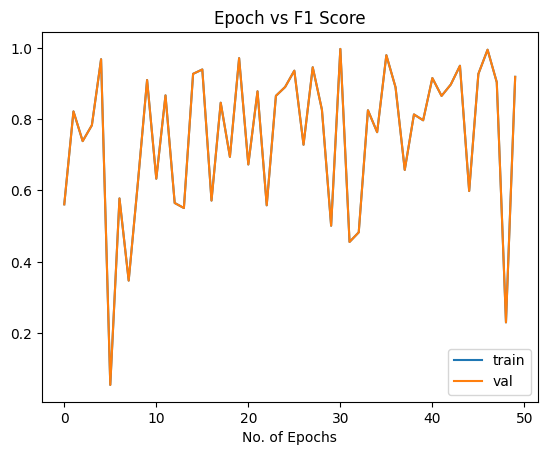

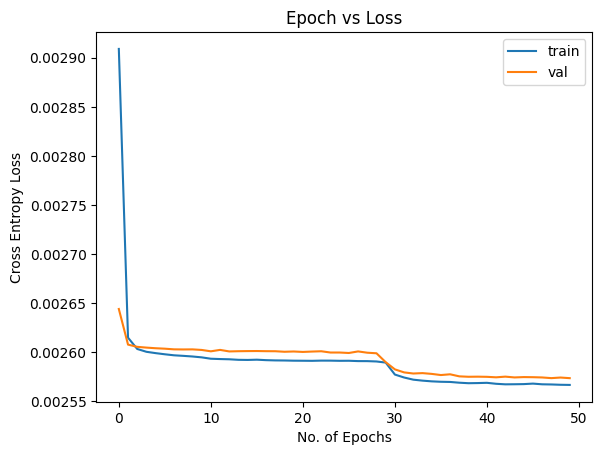

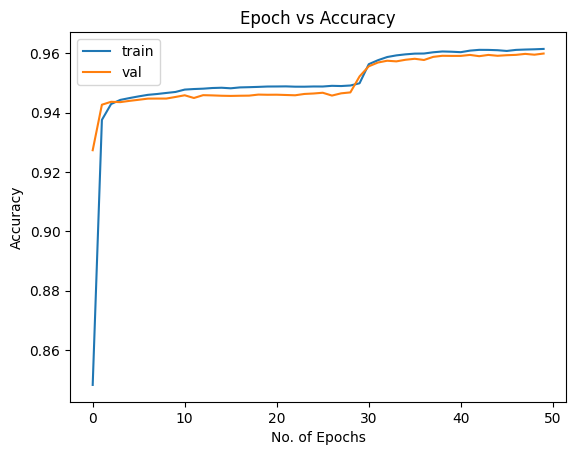

In [ ]:
def plot_training_loss(no_epochs, train_loss, test_loss, title):
    plt.figure()
    plt.plot(range(no_epochs), train_loss, label="train")
    plt.plot(range(no_epochs), test_loss, label="val")
    plt.xlabel("No. of Epochs")
    if "Loss" in title:
        plt.ylabel("Cross Entropy Loss")
    elif "Accuracy" in title:
        plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

plot_training_loss(best_track_early_stop + 1, best_dev_f1, best_dev_f1, "Epoch vs F1 Score")
plot_training_loss(best_track_early_stop + 1, best_train_loss_, best_dev_loss_, "Epoch vs Loss")
plot_training_loss(best_track_early_stop + 1, best_train_acc_, best_dev_acc_, "Epoch vs Accuracy")

# Testing:
After training the model with the best hyperparamters from the self-designed gridsearch, check the value of the f1_score for the test set.

In [ ]:
test_loss, test_acc, test_target, test_predicted = test_loop(test_dataloader, model, loss_fn, le)
test_score = calc_f1(test_target, test_predicted, le, test_len)
print(f"test loss: {test_loss:12.8f}\ttest Accuracy: {test_acc:12.8f}")

test loss:   0.00261247	test Accuracy:   0.94867784


# Q1.3d Report f1_score on development set for each epoch, as well as the f1_score for test set.

In [ ]:
for score in range(len(best_dev_f1)):
    print(f"epoch {score}:\t{best_dev_f1[score]}")

epoch 0:	0.5611234471583749
epoch 1:	0.8216654384672072
epoch 2:	0.7383716460367494
epoch 3:	0.7828179696616103
epoch 4:	0.9678973611967057
epoch 5:	0.0548372715113687
epoch 6:	0.5776940967992027
epoch 7:	0.347341878545913
epoch 8:	0.6219931271477663
epoch 9:	0.9096575606002308
epoch 10:	0.6330003444712365
epoch 11:	0.8665586842761026
epoch 12:	0.5649113233287858
epoch 13:	0.5507762789513871
epoch 14:	0.9269769201664776
epoch 15:	0.9391847157854913
epoch 16:	0.5717020640143584
epoch 17:	0.8459869848156183
epoch 18:	0.6942921942921944
epoch 19:	0.9709139724801431
epoch 20:	0.672905997998705
epoch 21:	0.8780038858779016
epoch 22:	0.5584035781868226
epoch 23:	0.8652831997808369
epoch 24:	0.890063653037005
epoch 25:	0.935835405833145
epoch 26:	0.7282534168304612
epoch 27:	0.9453801568360041
epoch 28:	0.8262791160660958
epoch 29:	0.5011756802149815
epoch 30:	0.996827148572217
epoch 31:	0.45567589249899715
epoch 32:	0.4826682717841589
epoch 33:	0.8248703482076708
epoch 34:	0.763381453098081


In [ ]:
print(f"Test f1 Score: {test_score}")

Test f1 Score: 0.9014981832661391
